In [ ]:
# Install gymnasium game environment
!pip install gymnasium[toy-text]

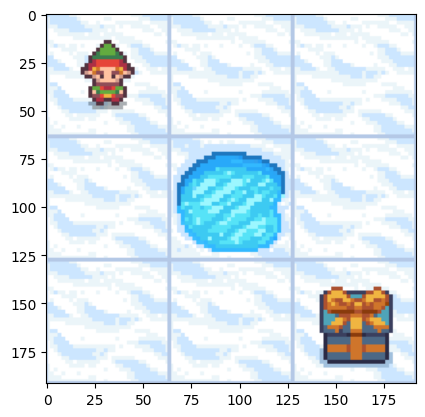

In [ ]:
# Load libraries
import gymnasium as gym
import numpy as np
import random
import matplotlib.pyplot as plt
import matplotlib
from keras.optimizers import Adam
from keras.layers import Dense
from keras.models import Sequential
from collections import deque
import imageio
import pandas as pd

# Define environment map
custom_map = [
    'SFF',
    'FHF',
    'FFG'
]

# Initialize the environment\
env = gym.make('FrozenLake-v1', desc=custom_map, is_slippery=False, render_mode='rgb_array')
state_size = env.observation_space.n    # Number of states
action_size = env.action_space.n    # Number of actions of this game: four, 0: left, 1:down, 2: right, 3: up.
env.reset()    # Reset environment, i.e., set agent position to state 0
plt.imshow(np.squeeze(env.render()) )   # Visualize environment map

In [ ]:
class Agent:
    def __init__(self, state_size, action_size):
        self.memory = deque(maxlen=2048)   # Deque is quick for append and pop operations from both the ends of the container.
        self.batch_size = 256    # Batch size of data samples for training policy (and target) network. In this example, the two networks are identical.
        self.learning_rate = 0.001    # Learning rate of
        self.epsilon = 1    # Start (max) value of epsilon
        self.min_eps = 0.01    # End (min) value of epsilon
        self.eps_decay = 0.003     # Decay factor for decreasing epsilon over episodes
        self.gamma = 0.9    # Discount factor
        self.state_size = state_size    # Number of states
        self.action_size = action_size    # Number of possible actions the agent can take: four, 0: left, 1:down, 2: right, 3: up.
        self.episode = 0     # Agent current episode
        self.max_steps = 50    # Maximum number of steps the agent can carry out in an episode
        self.train_episodes = 501    # Number of training episodes

        # Initialize policy and target networks
        self.policy_model = self.build_model()    # Agent policy model
        self.target_model = self.build_model()    # Target model (delayed copy of the policy model)
        self.target_model.set_weights(self.policy_model.get_weights())    # Copy the policy model weights to the target model

        # Set a parameter for when to update the target network
        self.update_target_frequency = 5    # Frequency at which to update the target network

    def build_model(self):
        model = Sequential()    # Initiate a simple sequential model
        model.add(Dense(10, input_dim=self.state_size, activation='relu'))    # Add a fully connected layer
        model.add(Dense(self.action_size, activation='linear'))    # Add a fully connected layer connecting to the network output
        model.compile(loss='mse', optimizer=Adam(learning_rate=self.learning_rate))    # Compile model with Mean Squared Error loss function
        return model

    def add_memory(self, state, action, reward, new_state, terminated):
        self.memory.append((state, action, reward, new_state, terminated))    # Insert the value in its argument to the right end of the deque

    def action(self, state):
        if np.random.rand() > self.epsilon:     # Epsilon starts at 1. rand > epsilon: exploit, rand <= epsilon: explore.
            return np.argmax(self.policy_model.predict(state, verbose=0))     # Take greedy action. Verbose=0 mutes output prediction log.
        return np.random.choice(self.action_size)    # Take a random action in the action space

    def replay(self):
        minibatch = random.sample(self.memory, self.batch_size)    # Select a data batch for training
        minibatch_state = np.concatenate(np.array(minibatch, dtype=object)[:, 0], axis=0)    # Extract 'state' batch from the data batch
        minibatch_action = np.array(minibatch, dtype=object)[:, 1]    # Extract 'action' batch from the data batch
        minibatch_reward = np.array(minibatch, dtype=object)[:, 2]    # Extract 'reward' batch from the data batch
        minibatch_new_state = np.concatenate(np.array(minibatch, dtype=object)[:, 3], axis=0)    # Extract 'new_state' batch from the data batch
        minibatch_terminated = np.array(minibatch, dtype=object)[:, 4]    # Extract 'terminated' batch from the data batch

        q_state = self.policy_model.predict(minibatch_state, verbose=0)    # First pass: feed current state to the network to get current Q-values
        q_new_state = self.target_model.predict(minibatch_new_state, verbose=0)    # Second pass: feed new state to the network to get next Q-values

        q_action_optimal = np.add(minibatch_reward, self.gamma * np.amax(q_new_state, axis=1))    # Calculate the optimal Q-values of actions from the current state
        for i in range(0, self.batch_size):
            q_state[i][minibatch_action[i]] = q_action_optimal[i]    # Update optimal Q-values back to 'q_state' variable

        self.policy_model.fit(minibatch_state, q_state, epochs=1, verbose=0)    # Train the network with the optimal Q-values, i.e., now in 'q_state' variable. x is minibatch_state and y is q_state. Loss is MSE.

    def update_target_network(self):
        # Update the target network by copying the policy network weights
        self.target_model.set_weights(self.policy_model.get_weights())
            # Logging and printing the results

    def save_model(self, name):
        self.policy_model.save_weights(name)

    def load_model(self, name):
        self.policy_model.load_weights(name)

# Initialize a reinforcement learning agent
agent = Agent(state_size, action_size)


In [ ]:
reward_episodes = []
step_episodes = []
epsilon_episodes = []

for episode in range(agent.train_episodes):
    agent.episode = episode  # Set agent's current episode
    state = env.reset()  # Reset environment, i.e., agent position is set to state 0
    state_arr = np.zeros(agent.state_size)  # Initialize current state array, e.g., [0. 0. 0. 0. 0. 0. 0. 0. 0.]
    state_arr[state[0]] = 1  # Set the agent position in the current state array, i.e., [[1. 0. 0. 0. 0. 0. 0. 0. 0.]]
    state_arr = np.reshape(state_arr, [1, agent.state_size])  # Reshape array
    reward = 0  # Initialize reward to zero
    terminated = False  # Initialize terminated to False

    img_lst = [env.render()]  # Initialize list to store visualization frames
    for step in range(agent.max_steps):
        action = agent.action(state_arr)  # Take action at the current state. This can be exploitation or exploration, depending on agent.epsilon
        new_state, reward, terminated, info, _ = env.step(action)  # Terminated: whether a terminal state is reached after taking the action. Ref: https://www.gymlibrary.dev/api/core/#gym.Env.step
        new_state_arr = np.zeros(agent.state_size)  # Initialize new state array, e.g., [[0. 0. 0. 0. 0. 0. 0. 0. 0.]]
        new_state_arr[new_state] = 1  # Set the agent position in the new state array, after taking the action, e.g., [[0. 1. 0. 0. 0. 0. 0. 0. 0.]]
        new_state_arr = np.reshape(new_state_arr, [1, agent.state_size])  # Reshape array
        agent.add_memory(state_arr, action, reward, new_state_arr, terminated)  # Add the current step to agent's memory
        state_arr = new_state_arr  # New state becomes state

        # Render the map image for visualization every K episodes
        if agent.episode % 50 == 0:
            animation_file = "training_episode_" + str(agent.episode) + "_steps_" + str(step) + ".gif"
            img = env.render()  # Render the current environment image
            img_lst.append(img)  # Append environment images to make animation

        if terminated:  # If the agent reaches the Goal
            break  # End the episode

    print("Episode: " + str(agent.episode) + ", Steps: " + str(step) + ", epsilon: " + str(round(agent.epsilon, 2)) + ", Reward: " + str(reward))
    reward_episodes.append(reward)  # Add the reward to the list for tracking purposes
    step_episodes.append(step)  # Add the step to the list for tracking purposes
    epsilon_episodes.append(agent.epsilon)  # Add the epsilon to the list for tracking purposes

    # Update epsilon value which is the ratio of exploitation and exploration
    if agent.epsilon < agent.min_eps:
        agent.epsilon = agent.min_eps  # Set the minimum value of epsilon so that there is always a chance for exploration.
    else:
        agent.epsilon = np.exp(-agent.eps_decay * agent.episode)  # Decrease exploration / Increase exploitation over time as the agent knows more about the environment

    # If enough experiences collected in the memory, use them for training
    if len(agent.memory) > agent.batch_size:
        agent.replay()

    # Update the target network after a certain number of episodes
    if episode % agent.update_target_frequency == 0:
        agent.update_target_network()

    # Write animation of the training episode (n*K)th
    if len(img_lst) > 1:
        imageio.mimsave(animation_file, img_lst, format='GIF', duration=0.5)

print('Average success rate of training episodes: ', round(np.mean(reward_episodes), 2))
agent.save_model('model_' + str(agent.episode))  # Save the model


Episode: 0, Steps: 1, epsilon: 1, Reward: 0.0
Episode: 1, Steps: 7, epsilon: 1.0, Reward: 0.0
Episode: 2, Steps: 2, epsilon: 1.0, Reward: 0.0
Episode: 3, Steps: 7, epsilon: 0.99, Reward: 0.0
Episode: 4, Steps: 6, epsilon: 0.99, Reward: 0.0
Episode: 5, Steps: 15, epsilon: 0.99, Reward: 0.0
Episode: 6, Steps: 3, epsilon: 0.99, Reward: 0.0
Episode: 7, Steps: 5, epsilon: 0.98, Reward: 0.0
Episode: 8, Steps: 3, epsilon: 0.98, Reward: 0.0
Episode: 9, Steps: 18, epsilon: 0.98, Reward: 0.0
Episode: 10, Steps: 8, epsilon: 0.97, Reward: 0.0
Episode: 11, Steps: 2, epsilon: 0.97, Reward: 0.0
Episode: 12, Steps: 1, epsilon: 0.97, Reward: 0.0
Episode: 13, Steps: 29, epsilon: 0.96, Reward: 1.0
Episode: 14, Steps: 7, epsilon: 0.96, Reward: 0.0
Episode: 15, Steps: 8, epsilon: 0.96, Reward: 0.0
Episode: 16, Steps: 6, epsilon: 0.96, Reward: 1.0
Episode: 17, Steps: 12, epsilon: 0.95, Reward: 0.0
Episode: 18, Steps: 2, epsilon: 0.95, Reward: 0.0
Episode: 19, Steps: 8, epsilon: 0.95, Reward: 0.0
Episode: 20

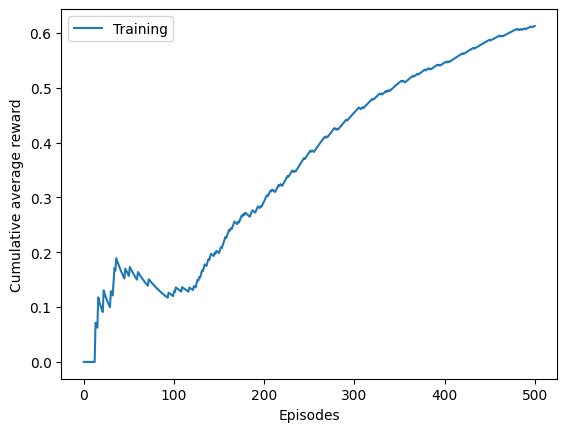

In [ ]:
# Plot cumulative average reward (or success rate) of the training phase.
# This shows how well the agent performs in the training phase.
df_reward_episodes = pd.DataFrame(reward_episodes)
cumulative_average_rewards = df_reward_episodes.expanding().mean()
plt.plot(cumulative_average_rewards)
plt.ylabel('Cumulative average reward')
plt.xlabel('Episodes')
plt.legend(['Training'], loc='upper left')
matplotlib.rcParams.update({'font.size': 10})
plt.show()

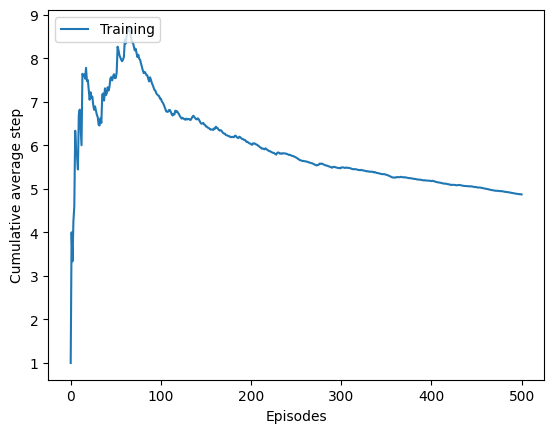

In [ ]:
# Plot cumulative average steps of the training phase.
# This shows how well the agent performs in the training phase.
df_step_episodes = pd.DataFrame(step_episodes)
cumulative_average_steps = df_step_episodes.expanding().mean()
plt.plot(cumulative_average_steps)
plt.ylabel('Cumulative average step')
plt.xlabel('Episodes')
plt.legend(['Training'], loc='upper left')
matplotlib.rcParams.update({'font.size': 10})
plt.show()

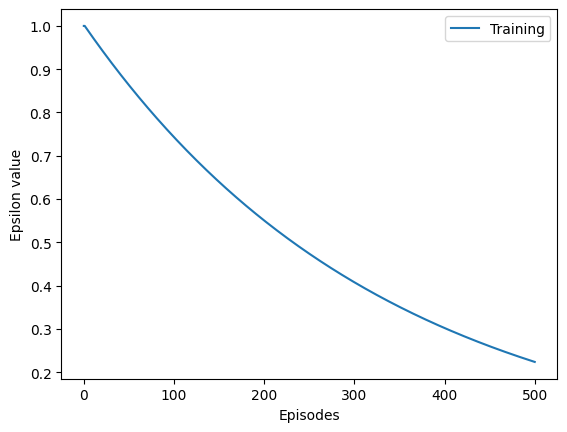

In [ ]:
# Plot epsilon values over episodes
plt.plot(epsilon_episodes)
plt.ylabel('Epsilon value')
plt.xlabel('Episodes')
plt.legend(['Training'], loc='upper right')
matplotlib.rcParams.update({'font.size': 10})
plt.show()

In [ ]:
# Print the optimal policy, i.e., at each state what is the best action to take.
for state_index in range(agent.state_size):
    state_arr = np.zeros(agent.state_size)    # Initialize state array, e.g., [[0. 0. 0. 0. 0. 0. 0. 0. 0.]]
    state_arr[state_index] = 1    # Set the agent position as if it is currently at each of the state
    state_arr = np.reshape(state_arr, [1, agent.state_size])    # Reshape state array
    q_values = agent.policy_model.predict(state_arr, verbose=0)    # Get Q-values of all actions of the current state from the policy network
    best_action = np.argmax(q_values)    # Get max-Q-value action, i.e., best action to take
    print("State " + str(state_index) + ", Best action: " + str(best_action))


State 0, Best action: 2
State 1, Best action: 2
State 2, Best action: 1
State 3, Best action: 1
State 4, Best action: 2
State 5, Best action: 1
State 6, Best action: 2
State 7, Best action: 2
State 8, Best action: 0


In [ ]:
# Load the saved agent model.
# agent.load_model('model_500')    # Uncomment this line if you want to load a saved model from file

# Test an episode
state = env.reset()    # Reset environment, i.e., agent position is set to state 0
state_arr = np.zeros(agent.state_size)    # Initialze current state array, e.g., [0. 0. 0. 0. 0. 0. 0. 0. 0.]
state_arr[state[0]] = 1    # Set the agent position in the current state array, i.e., [1. 0. 0. 0. 0. 0. 0. 0. 0.]
state_arr = np.reshape(state_arr, [1, agent.state_size])    # Reshape array, e.g., [[1. 0. 0. 0. 0. 0. 0. 0. 0.]]
terminated = False    # Initialize terminated to False
img_lst = [env.render()]    # Initialize list to store visualization frames
for step in range(agent.max_steps):
    q_values = agent.policy_model.predict(state_arr, verbose=0)    # Get Q-values of all actions of the current state
    best_action = np.argmax(q_values)    # Get max-Q-value action, i.e., best action to take
    new_state, reward, terminated, info, _ = env.step(best_action)    # Perform the best action, get return from environment
    new_state_arr = np.zeros(agent.state_size)    # Initialze new state array, e.g., [0. 0. 0. 0. 0. 0. 0. 0. 0.]
    new_state_arr[new_state] = 1    # Set the agent position in the new state array, after taking the action, e.g., [0. 1. 0. 0. 0. 0. 0. 0. 0.]
    new_state_arr = np.reshape(new_state_arr, [1, agent.state_size])    # Reshape array, e.g., [[0. 1. 0. 0. 0. 0. 0. 0. 0.]]
    print("Current state: " + str(np.argmax(state_arr)) + ", Action: " + str(best_action) + ", New state: " + str(np.argmax(new_state_arr)))
    state_arr = new_state_arr    # New state becomes state

    img = env.render()    # Render current environment image
    img_lst.append(img)    # Append environment images to make animation

    if terminated:    # If agent reaches Goal or Hole
        break    # End episode

print("Reward: " + str(reward))    # Print reward of the test episode
imageio.mimsave('test.gif', img_lst, format='GIF', duration=0.5)

Current state: 0, Action: 2, New state: 1
Current state: 1, Action: 2, New state: 2
Current state: 2, Action: 1, New state: 5
Current state: 5, Action: 1, New state: 8
Reward: 1.0


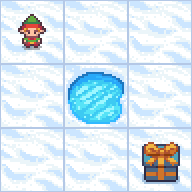

In [ ]:
# Display test result animation
from IPython.display import Image
Image('test.gif')

# Compare and Discuss performance

I think the performance of the optimal policy is similar in both approaches (1) one policy network and (2) one policy network and one target network. It takes the agent the similar amount of steps in both case to reach the goal. The cumulative average reward and step are similar in both case. However, I do think that in term of convergence stability, the approach with both policy and target network seems to perform better since the graphs above are less fluctuated compared to the one with only one policy network.